# FourDs

We discovered that the MixtureModelClassifier doesn't perform very well. We would like to experiment somewhat further to discover why it does/does not.

relevant articles:
- [in depth](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)

In [1]:
## Imports ##

# numpy
import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split

# skactiveml
from skactiveml.classifier import SklearnClassifier, MixtureModelClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import FourDs
from skactiveml.utils import MISSING_LABEL

# plot function
from plot_accuracy import plot_accuracy

# balanced accuracy
from balanced_accuracy import balanced_accuracy

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

We will compare the query by committee strategy against the standard uncertainty sampling.

In [2]:
def get_accuracy_uncertainty(classifier, weights=None, cycles=30, n_samples=400, **kwargs):
    data = []
    for rand in range(100):
        qs = UncertaintySampling(random_state=rand, **kwargs)
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        Xf, Xt, yf, yt = train_test_split(X, y, random_state=rand)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        out = []
        clf = SklearnClassifier(classifier, classes=np.unique(yf))

        clf.fit(Xf, y)
        for _ in range(cycles):
            i = qs.query(Xf, y, clf)
            y[i] = yf[i]
            clf.fit(Xf,y)
            predicted_y = clf.predict(Xt)
            out.append(balanced_accuracy(yt, predicted_y))
        data.append(out)

    return np.mean(np.array(data), axis=0)

def get_accuracy_fourDs(weights=None, cycles=30, n_samples=400, **kwargs):
    data = []
    for rand in range(100):
        qs = FourDs(random_state=rand, **kwargs)
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        Xf, Xt, yf, yt = train_test_split(X, y, random_state=rand)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        out = []
        mixture_model=BayesianGaussianMixture(n_components=20, covariance_type="full")
        clf = MixtureModelClassifier(mixture_model=mixture_model, classes=np.unique(yf))
        clf.fit(Xf, y)
        
        for _ in range(cycles):
            i = qs.query(Xf, y, clf)
            y[i] = yf[i]

            clf.fit(Xf,y)
            predicted_y = clf.predict(Xt)
            out.append(balanced_accuracy(yt, predicted_y))
        data.append(out)

    return np.mean(np.array(data), axis=0)

In [3]:
acc_uncertainty = get_accuracy_uncertainty(LogisticRegression(), weights=[0.8, 0.2])

In [4]:
acc_fourDs = get_accuracy_fourDs(weights=[0.8, 0.2])

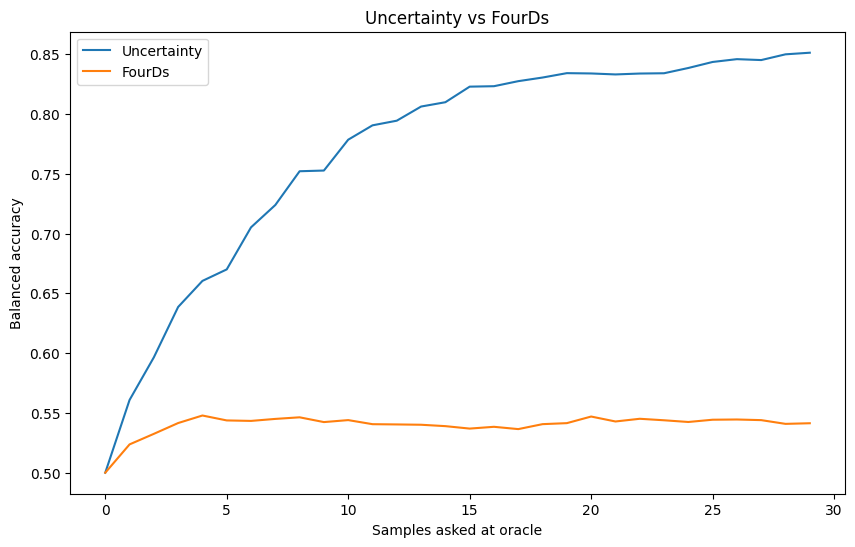

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

plot_accuracy('Uncertainty vs FourDs', [[acc_uncertainty, "Uncertainty"], [acc_fourDs, "FourDs"]], axs)

fig.show()

We will compare this with the same example without imbalance to compare if class imbalance has a big effect.

In [6]:
acc_uncertainty_no_imbalance = get_accuracy_uncertainty(LogisticRegression(), weights=[0.5, 0.5])

In [7]:
acc_fourDs_no_imbalance = get_accuracy_fourDs(weights=[0.5, 0.5])

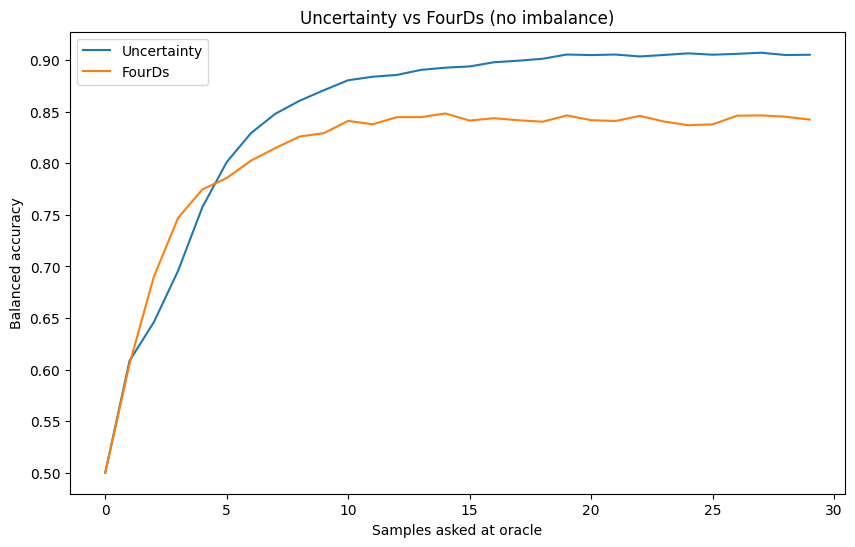

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

plot_accuracy('Uncertainty vs FourDs (no imbalance)', [[acc_uncertainty_no_imbalance, "Uncertainty"], 
                                                       [acc_fourDs_no_imbalance, "FourDs"]], axs)

fig.show()

We can clearly see that the MixtureModel classifier doesn't perform well with imbalanced data and should be avoided